In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil, pathlib

# initialize the seeds of different random number generators so that
# the results will be similar every time the notebook is run
keras.utils.set_random_seed(42)

Instead of using the dataset that comes packaged with keras, we will now work with approximately 200 web-scraped color images of handbags and shoes with 100 each.

Is "Deep Learning" even possible with so few examples?
YES!
We will now build a near-perfect handbags vs shoes classifier using just 200 images!



In [2]:
content_dir = pathlib.Path("/content")

for path in content_dir.glob("handbags-shoes.zip*"):
    if path.is_dir():
        shutil.rmtree(path)
        print(f"Removed directory: {path}")
    else:
        path.unlink()
        print(f"Removed file: {path}")

!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip
print(f"Downloaded the zip file: {content_dir/'handbags-shoes.zip'}")

Removed file: /content/handbags-shoes.zip
Downloaded the zip file: /content/handbags-shoes.zip


In [3]:
basedir = content_dir/'handbags-shoes'
if basedir.exists():
    shutil.rmtree(basedir)
    print(f"Deleted: {basedir}")

!unzip -qq handbags-shoes.zip
print(f"Unzipped file: {basedir}")

Deleted: /content/handbags-shoes
Unzipped file: /content/handbags-shoes


Since, this isn't a standard Keras dataset, we will need to split train/validation/test sets ourselves.

In [4]:
for category in ('handbags', 'shoes'):
    fnames = os.listdir(basedir/category)

    dir = basedir/'train'/category
    os.makedirs(dir)

    # the first 50 examples go into the training set
    for fname in fnames[:50]:
        shutil.copyfile(src=basedir/category/fname, dst=dir/fname)

    dir = basedir/'validation'/category
    os.makedirs(dir)

    # the next 25 examples go into the validation set
    for fname in fnames[50:75]:
        shutil.copyfile(src=basedir/category/fname, dst=dir/fname)

    dir = basedir/'test'/category
    os.makedirs(dir)

    # the remaining examples go into the test set
    for fname in fnames[75:]:
        shutil.copyfile(src=basedir/category/fname, dst=dir/fname)

The code above creates this directory structure:

train/  
..handbags/  
..shoes/  

validation/  
..handbags/  
..shoes/  

test/  
..handbags/  
..shoes/  

When working with image JPEGs, we will follow this process:

1.   Read in the JPEGs
2.   Convert the JPEGs into tensors
3.   Resize them to a standard size (since web-scraped images may be in different sizes)
5.   Group them into batches (we’ll use batches of 32 images).


Fortunately, Keras gives us a single function that does all these in one shot! (Ref: [image manipulation functions](https://keras.io/api/preprocessing/image/))

In [5]:
train_dataset = keras.utils.image_dataset_from_directory(
    basedir/'train',
    image_size=(224,224),
    batch_size=32
)

validation_dataset = keras.utils.image_dataset_from_directory(
    basedir/'validation',
    image_size=(224,224),
    batch_size=32
)

test_dataset = keras.utils.image_dataset_from_directory(
    basedir/'test',
    image_size=(224,224),
    batch_size=32
)

Found 97 files belonging to 2 classes.
Found 48 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


**Less than 100 examples in the training set!!**

Let's check the shape of each image. Since these are color images, they will have 3 channels and since we sized them to (224, 224) 👆, the shape should be (224, 224, 3).

In [6]:
for images, _ in train_dataset.take(1):
  print(images[0].shape)

(224, 224, 3)


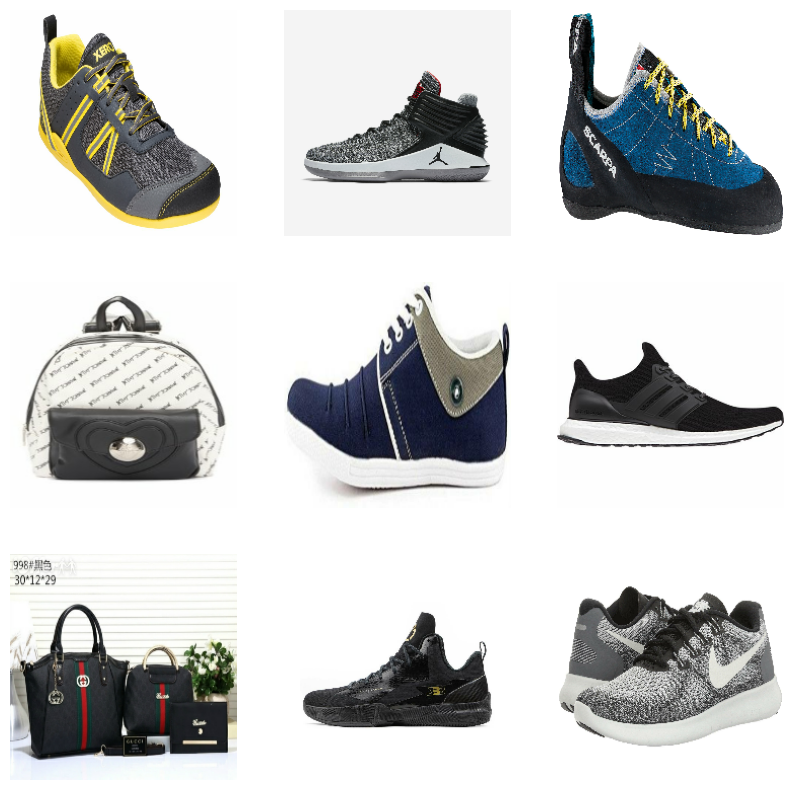

In [7]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## A Basic Conventional Neural Network (CNN) Model with two Convolutional Blocks

In [8]:
input = keras.Input(shape=(224, 224, 3))

# we normalize the input "inside" the model with Rescaling factor
# so that we dont have to remember to do it every time
# we neeed to use the model to make a prediction
h = keras.layers.Rescaling(1./255)(input)

# first convolutional block
h = keras.layers.Conv2D(
    32,                 # number of filters
    kernel_size=(2,2),  # the shape of each filter
    activation="relu",
    name="Conv_1"
)(h)
h = keras.layers.MaxPool2D()(h)

# second convolutional block
h = keras.layers.Conv2D(
    32,                 # number of filters
    kernel_size=(2,2),  # the shape of each filter
    activation="relu",
    name="Conv_2"
)(h)
h = keras.layers.MaxPool2D()(h)

# flatten layer
h = keras.layers.Flatten()(h)

output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 110, 110, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        96,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,345 (395.88 KB)

 Trainable params: 101,345 (395.88 KB)

 Non-trainable params: 0 (0.00 B)

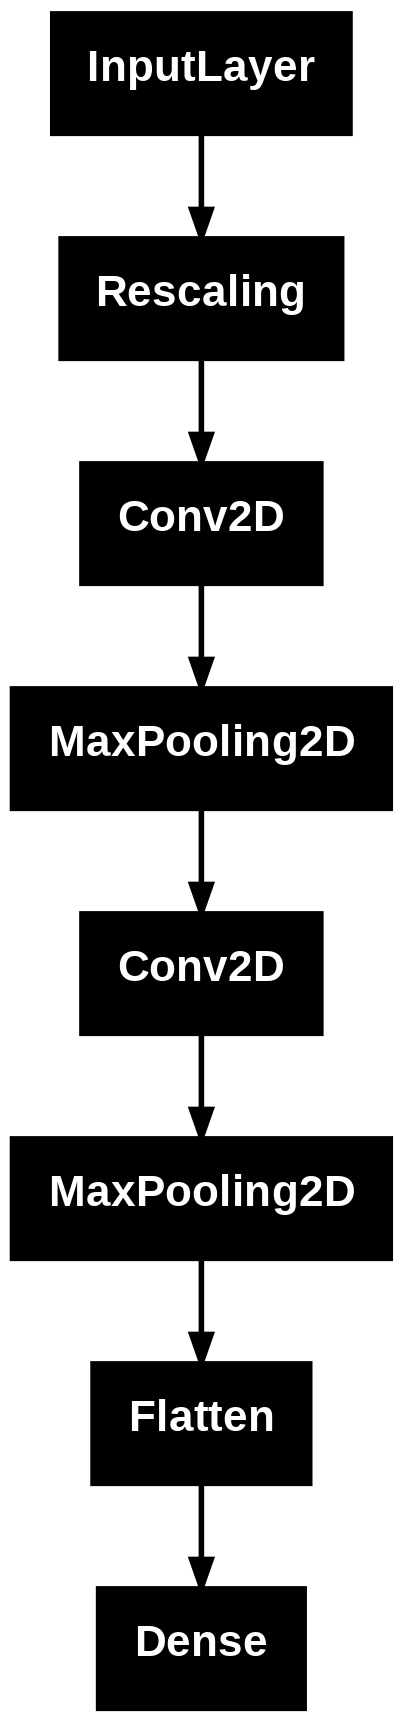

In [10]:
keras.utils.plot_model(model)

In [11]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Note that we have chosen the `binary_cross_entropy` loss function since the problem is of binary classification type (e.g. handbags or shoes)

In [12]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data = validation_dataset
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4647 - loss: 1.5348 - val_accuracy: 0.5000 - val_loss: 1.8806
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5073 - loss: 2.0093 - val_accuracy: 0.5000 - val_loss: 0.8939
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5921 - loss: 0.7319 - val_accuracy: 0.5000 - val_loss: 0.9289
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5073 - loss: 0.8375 - val_accuracy: 0.5417 - val_loss: 0.6791
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7290 - loss: 0.5481 - val_accuracy: 0.5000 - val_loss: 0.7074
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 998ms/step - accuracy: 0.5571 - loss: 0.5914 - val_accuracy: 0.5417 - val_loss: 0.6431
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8380 - loss: 0.4675 - val_accuracy: 0.6875 - val_loss: 0.5989
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8195 - loss: 0.4506 - val_accuracy: 0.5417 - val_loss: 0.6343
Epoch 9/20


In [13]:
def plot_loss_curves(history):
  plt.clf()
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def plot_acc_curves(history):
  plt.clf()
  history_dict = history.history
  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

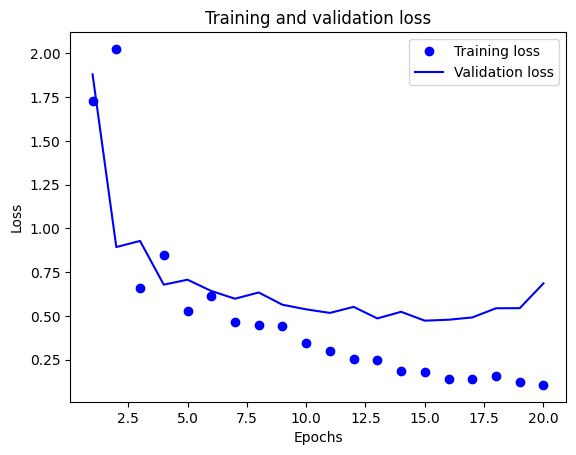

In [14]:
plot_loss_curves(history)

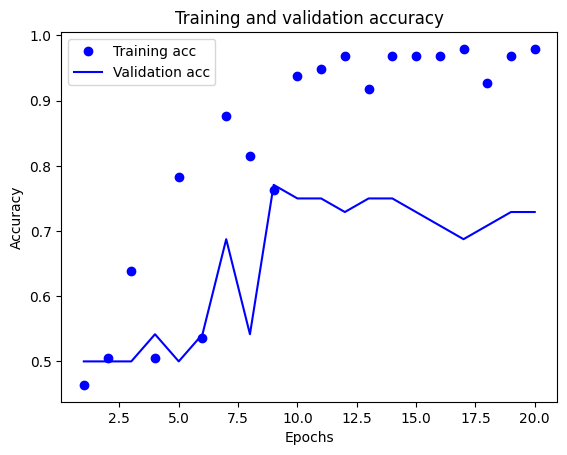

In [15]:
plot_acc_curves(history)

The model achieves a high training accuracy. This is not surprising, since our training dataset has only ~90 examples while our model has 101,345 parameters!

The validation accuracy curve is very noisy because the validation dataset is only 49 examples but it is clear there's a gap between training and validation accuracy curves, suggesting **overfitting**.

Let's check the accuracy on the test set.

In [16]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7229 - loss: 0.4227


[0.41934704780578613, 0.7250000238418579]

OK, what can we do to improve accuracy?

We can go back and scrape more data, of course, but that is a lot of work.

What else?

## Data Augmentation for Images

The basic idea of augmentation is to slightly alter the image so that the value of the dependent variable (i.e. the category that it belongs to) doesn't change. For instance, if you rotate the image of a handbag by 10 degrees or zoom in on it slightly, the content of the image doesn't change; it is *still* a handbag.

By applying these transformations repeatedly to an image, you can create new images and thereby increase the size of the dataset almost effortlessly.

Researchers have developed a list of these transformations that you can apply to images and Keras provides them out of the box as different kinds of *layers*.



---



---



To demonstrate, here's a little function that applies three transformations to an incoming image.

In [17]:
def augment_data(image):
  x = keras.layers.RandomFlip("horizontal")(image)
  x = keras.layers.RandomRotation(0.1)(x)
  x = keras.layers.RandomZoom(0.2)(x)
  return x

Let's apply it to an image from our training set to see what it produces.

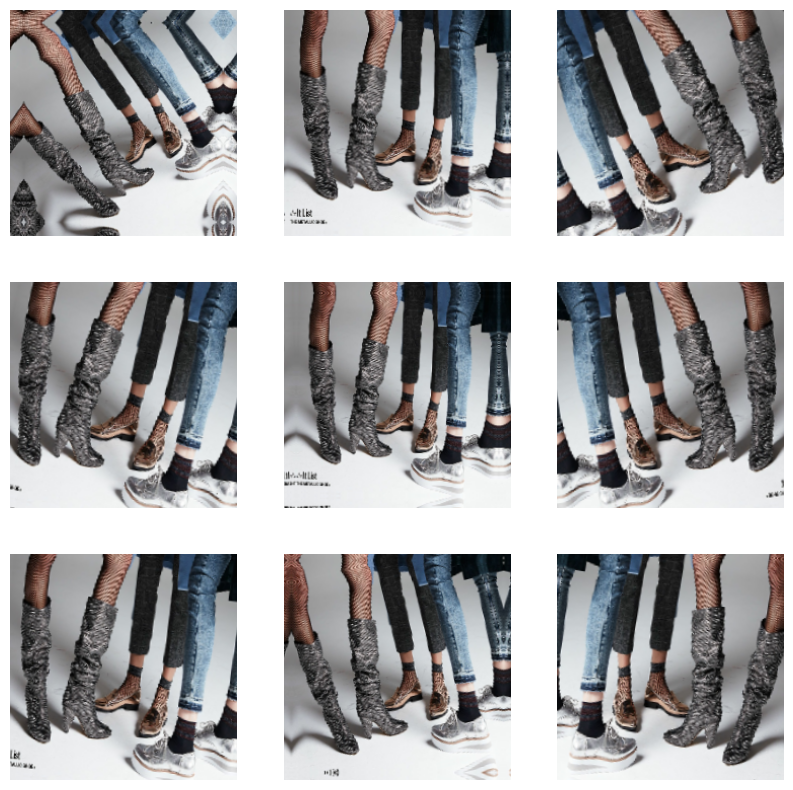

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_data(images[0])
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.axis("off")

We can insert these  data augmentation layers right after the input layer in the convolutional NN model we built earlier, and train the model as before. Also, because we have effectively more data now, we can train this data-augmented model for more epochs at a lower risk of overfitting.

In [19]:
input = keras.Input(shape=(224,224,3))

# we insert the data augmentation layers here
h = keras.layers.RandomFlip("horizontal")(input)
h = keras.layers.RandomRotation(0.1)(h)
h = keras.layers.RandomZoom(0.2)(h)

# rest of the model is the same as before

h = keras.layers.Rescaling(1./255)(h)


# first convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_1")(h)
h = keras.layers.MaxPool2D()(h)


# second convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_2")(h)
h = keras.layers.MaxPool2D()(h)

# flatten layer
h = keras.layers.Flatten()(h)

# output layer
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_9 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_9               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 110, 110, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        96,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,345 (395.88 KB)

 Trainable params: 101,345 (395.88 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5363 - loss: 0.9343 - val_accuracy: 0.5208 - val_loss: 0.9726
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5975 - loss: 0.7243 - val_accuracy: 0.6458 - val_loss: 0.6182
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7033 - loss: 0.5943 - val_accuracy: 0.6667 - val_loss: 0.6097
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7127 - loss: 0.5102 - val_accuracy: 0.7917 - val_loss: 0.5205
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7967 - loss: 0.4641 - val_accuracy: 0.7292 - val_loss: 0.5487
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8538 - loss: 0.4242 - val_accuracy: 0.7292 - val_loss: 0.5473
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7883 - loss: 0.4458 - val_accuracy: 0.6875 - val_loss: 0.8404
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7573 - loss: 0.4679 - val_accuracy: 0.7917 - val_loss: 0.6256
Epoch 9/10
4/